In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 19.1 MB/s eta 0:00:00


In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchtext
import json
import random
import os
from scipy import interpolate

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Data

In [ ]:
!unzip wikipedia_data_v1.zip

In [ ]:
!unzip wikipedia_data_v2.zip

In [ ]:
def extract_text(folder_name):
  folder_names = os.listdir(folder_name)
  # put all text in a list
  text = []
  for folder in folder_names:
    with open(folder_name + '/' + folder + '/text.json') as file:
      file_content = file.read()
      file_content_str = json.loads(file_content)
      # need to convert the file content to a dict to extract text
      file_content_dict = json.loads(file_content_str)
      text.append(file_content_dict["text"])
  return text

In [ ]:
text = extract_text('wikipedia_data_v1')

In [ ]:
text[32]

'300px|thumb|The asteroids of the inner Solar System and Jupiter: The donut-shaped asteroid belt is located between the orbits of Jupiter and Mars.\nthumb|299x299px|The relative masses of the top twelve asteroids known compared to the remaining mass of all the other asteroids in the belt.\n300px|thumb|By far the largest object within the belt is Ceres. The total mass of the asteroid belt is significantly less than Pluto\'s, and approximately twice that of Pluto\'s moon Charon.\n\nThe asteroid belt is the circumstellar disc in the Solar System located roughly between the orbits of the planets Mars and Jupiter. It is occupied by numerous irregularly shaped bodies called asteroids or minor planets. The asteroid belt is also termed the main asteroid belt or main belt to distinguish it from other asteroid populations in the Solar System such as near-Earth asteroids and trojan asteroids. About half the mass of the belt is contained in the four largest asteroids: Ceres, Vesta, Pallas, and Hyg

In [ ]:
text2 = extract_text('wikipedia_data_v2')

### Tokenizers and Models

In [ ]:
tokenizergpt2 = GPT2Tokenizer.from_pretrained("gpt2")
tokenizergpt2.padding_side = "left"
tokenizergpt2.pad_token = tokenizergpt2.eos_token

In [ ]:
modelgpt2 = GPT2LMHeadModel.from_pretrained("gpt2")
modelgpt2.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
tokenizergpt2(tokenizergpt2.eos_token)

{'input_ids': [50256], 'attention_mask': [1]}

In [ ]:
tokenizergpt2.eos_token

'<|endoftext|>'

In [ ]:
tokenizergpt2_large = GPT2Tokenizer.from_pretrained("gpt2-xl")
tokenizergpt2_large.padding_side = "left"
tokenizergpt2_large.pad_token = tokenizergpt2_large.eos_token

In [ ]:
all_possible_tokens = list(tokenizergpt2_large.get_vocab().keys())
print(all_possible_tokens)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '¡', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '®', '¯', '°', '±', '²', '³', '´', 'µ', '¶', '·', '¸', '¹', 'º', '»', '¼', '½', '¾', '¿', 'À', 'Á', 'Â', 'Ã', 'Ä', 'Å', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Ë', 'Ì', 'Í', 'Î', 'Ï', 'Ð', 'Ñ', 'Ò', 'Ó', 'Ô', 'Õ', 'Ö', '×', 'Ø', 'Ù', 'Ú', 'Û', 'Ü', 'Ý', 'Þ', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ð', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', '÷', 'ø', 'ù', 'ú', 'û', 'ü', 'ý', 'þ', 'ÿ', 'Ā', 'ā', 'Ă', 'ă', 'Ą', 'ą', 'Ć', 'ć', 'Ĉ', 'ĉ', 'Ċ', 'ċ'

In [ ]:
modelgpt2_large = GPT2LMHeadModel.from_pretrained("gpt2-xl")
modelgpt2_large.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50257, bias=False)
)

### Functions

In [ ]:
# encode all the text
def encode(text, tokenizer):
  inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=1001)
  #inputs.to(device);
  # remove examples that don't have a 1000 tokens
  long_enough_rows = torch.nonzero(inputs["input_ids"][:, 0] != 50256).squeeze()
  input_ids = inputs["input_ids"][long_enough_rows]
  attention_mask = inputs["attention_mask"][long_enough_rows]
  return input_ids, attention_mask

In [ ]:
def measure_accuracy(input_ids, attention_mask, model, context_lengths, batch_size, file_name):
  # construct contexts and run batch generation
  # key is context length, value is the accuracy (number of correct next token predictions divided by number of examples)
  output_dict = {}
  for c in context_lengths:
    print(c)
    output_dict[c] = 0
    if c >= 700:
      batch_size_to_use=2
    else:
      batch_size_to_use=batch_size
    print(batch_size_to_use)
    for b in range(0, input_ids.size()[0], batch_size_to_use):
      # get the last batch
      if b > input_ids.size()[0]:
        input_ids_curr = input_ids[b-batch_size_to_use:, 0:c]
        attention_mask_curr = attention_mask[b-batch_size_to_use:, 0:c]
        correct_tokens = input_ids[b-batch_size_to_use:, c]
      else:
        input_ids_curr = input_ids[b:b+batch_size_to_use, 0:c]
        attention_mask_curr = attention_mask[b:b+batch_size_to_use, 0:c]
        correct_tokens = input_ids[b:b+batch_size_to_use, c]
      input_ids_curr = input_ids_curr.to(device);
      attention_mask_curr = attention_mask_curr.to(device);
      correct_tokens = correct_tokens.to(device);
      pred = model.generate(input_ids=input_ids_curr, attention_mask=attention_mask_curr, do_sample=False, max_new_tokens=1, pad_token_id=50256)
      predicted_tokens = pred[:, -1]
      accuracy = torch.eq(predicted_tokens, correct_tokens).sum().item()
      output_dict[c] += accuracy

    output_dict[c] = output_dict[c]/input_ids.size()[0]

  with open(file_name, "w") as file:
    json.dump(output_dict, file)
  return output_dict

### Experiments

Experiments:
- GPT-2 small, 45 ex, 25 context length
- GPT-2 x-large, 45 ex, 25 context length
- GPT-2 small, 45 ex, 33 context length
- GPT-2 x-large, 45 ex, 33 context length
- GPT-2 small, 75 ex, 33 context length
- GPT-2 x-large, 75 ex, 33 context length

Notes:

data_v1: 49 examples

data_v2: 75 examples

cl_v1: context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 700, 1000]

cl_v2: context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]


In [ ]:
def plot(output_filename, label_line):
  # plot
  with open(output_filename) as f:
    content = f.read()
  acc = json.loads(content)
  x = np.array(list(acc), dtype='float64')
  y = np.array(list(acc.values()), dtype='float64')
  m, b = np.polyfit(np.log10(x), y, 1)
  plt.figure(figsize=(10, 5))
  plt.plot(x, y, label=label_line)
  plt.plot(x, m*np.log10(x) + b, label="Line of best fit", linewidth=0.7, color='purple')
  plt.xscale('log')
  plt.legend()
  plt.xlabel("Context length")
  plt.ylabel("Accuracy")
  plt.title("Average accuracy as a function of context length")
  plt.show()

##### GPT-2 small, 25 context lengths, 49 examples

In [ ]:
input_ids, attention_mask = encode(text=text, tokenizer=tokenizergpt2)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 700, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2, context_lengths=context_lengths, batch_size=16, file_name = "gpt2small_datav1_clv1.json")

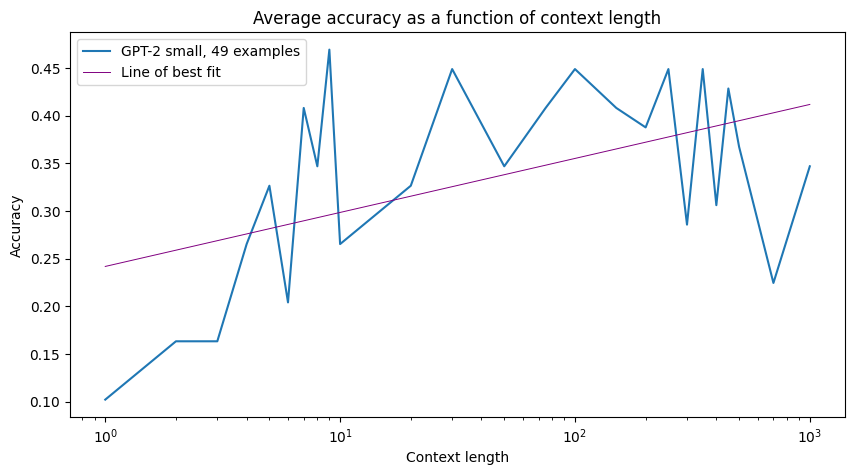

In [ ]:
plot(output_filename="gpt2small_datav1_clv1.json", label_line='GPT-2 small, 49 examples')

##### GPT-2 x-large, 25 context lengths, 49 examples

In [ ]:
input_ids, attention_mask = encode(text=text, tokenizer=tokenizergpt2_large)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 700, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2_large, context_lengths=context_lengths, batch_size=8, file_name = "gpt2large_datav1_clv1.json")

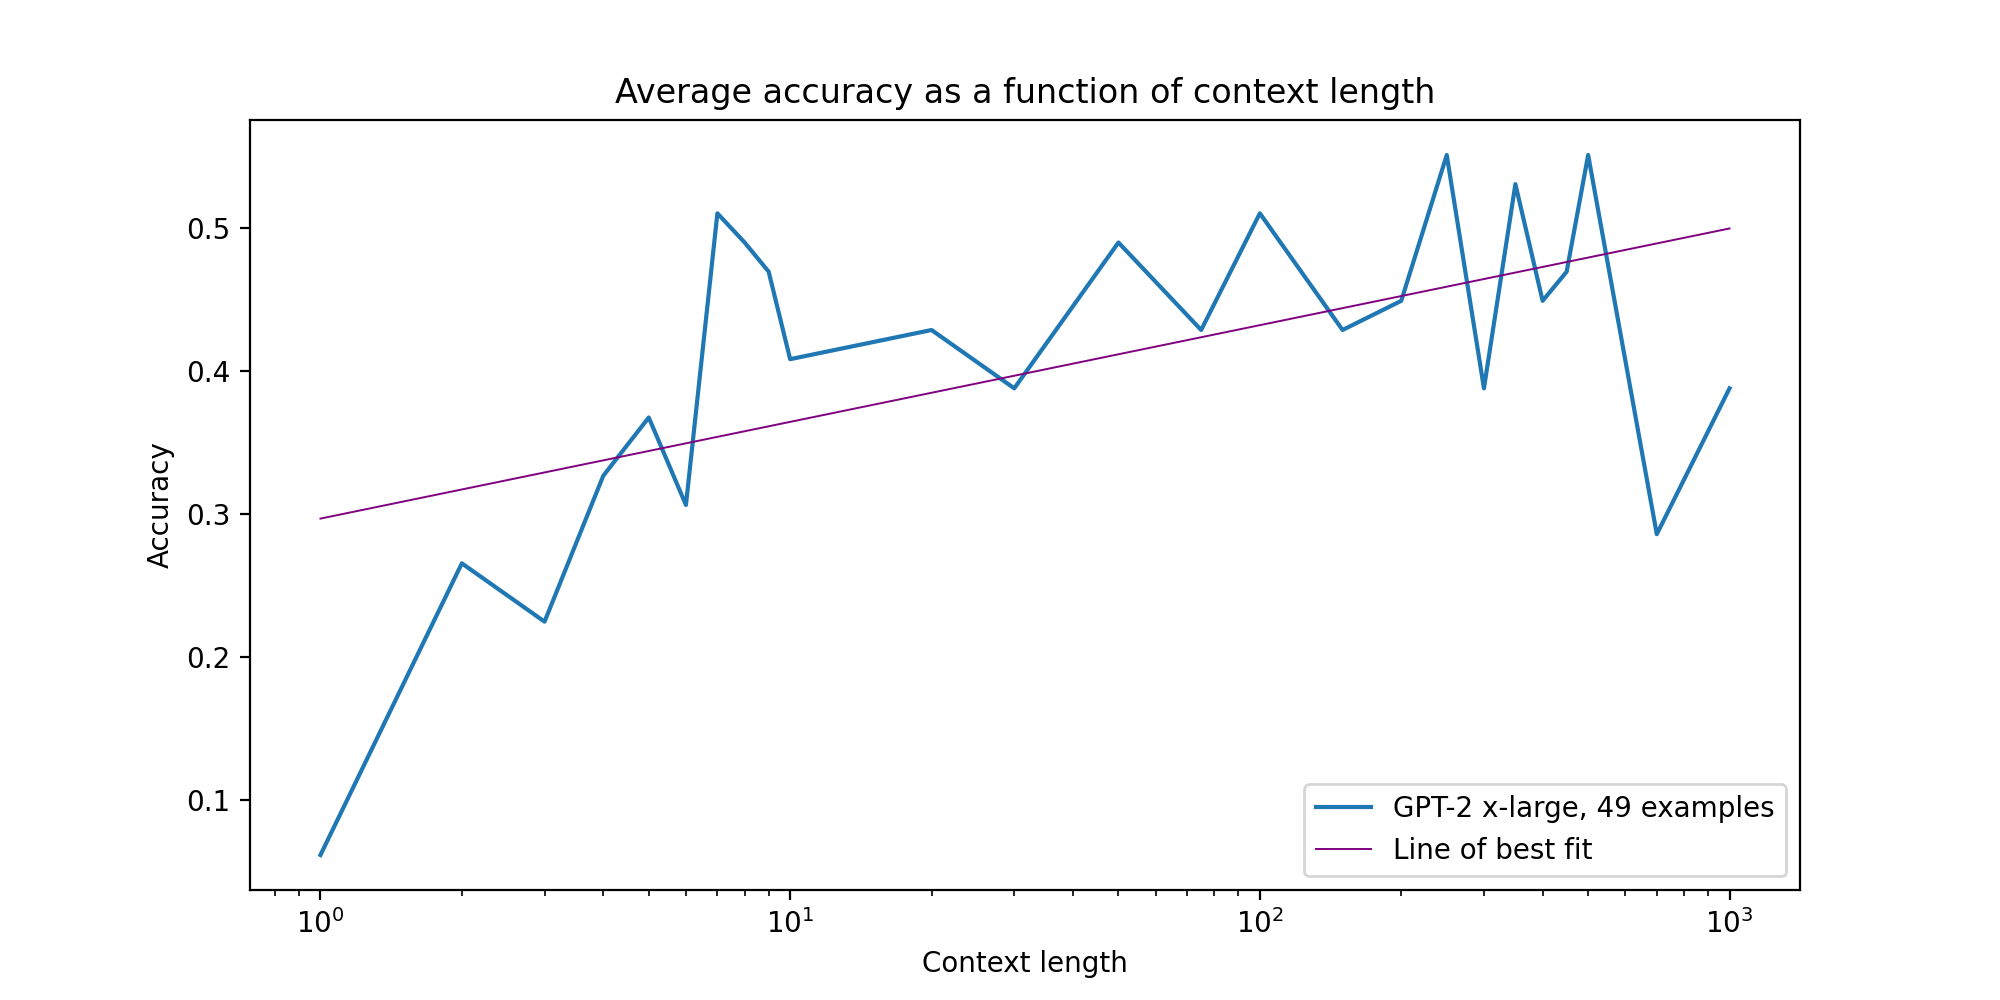

In [ ]:
plot(output_filename="gpt2large_datav1_clv1.json", label_line='GPT-2 x-large, 49 examples')

##### GPT-2 small, 33 context lengths, 49 examples

In [ ]:
input_ids, attention_mask = encode(text=text, tokenizer=tokenizergpt2)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2, context_lengths=context_lengths, batch_size=16, file_name = "gpt2small_datav1_clv2.json")

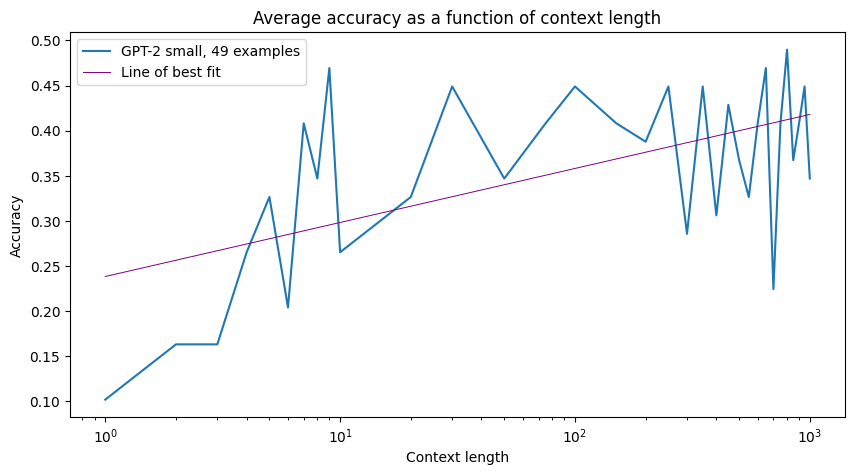

In [ ]:
plot(output_filename="gpt2small_datav1_clv2.json", label_line='GPT-2 small, 49 examples')

##### GPT-2 x-large, 33 context lengths, 49 examples

In [ ]:
input_ids, attention_mask = encode(text=text, tokenizer=tokenizergpt2_large)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2_large, context_lengths=context_lengths, batch_size=8, file_name = "gpt2large_datav1_clv2.json")

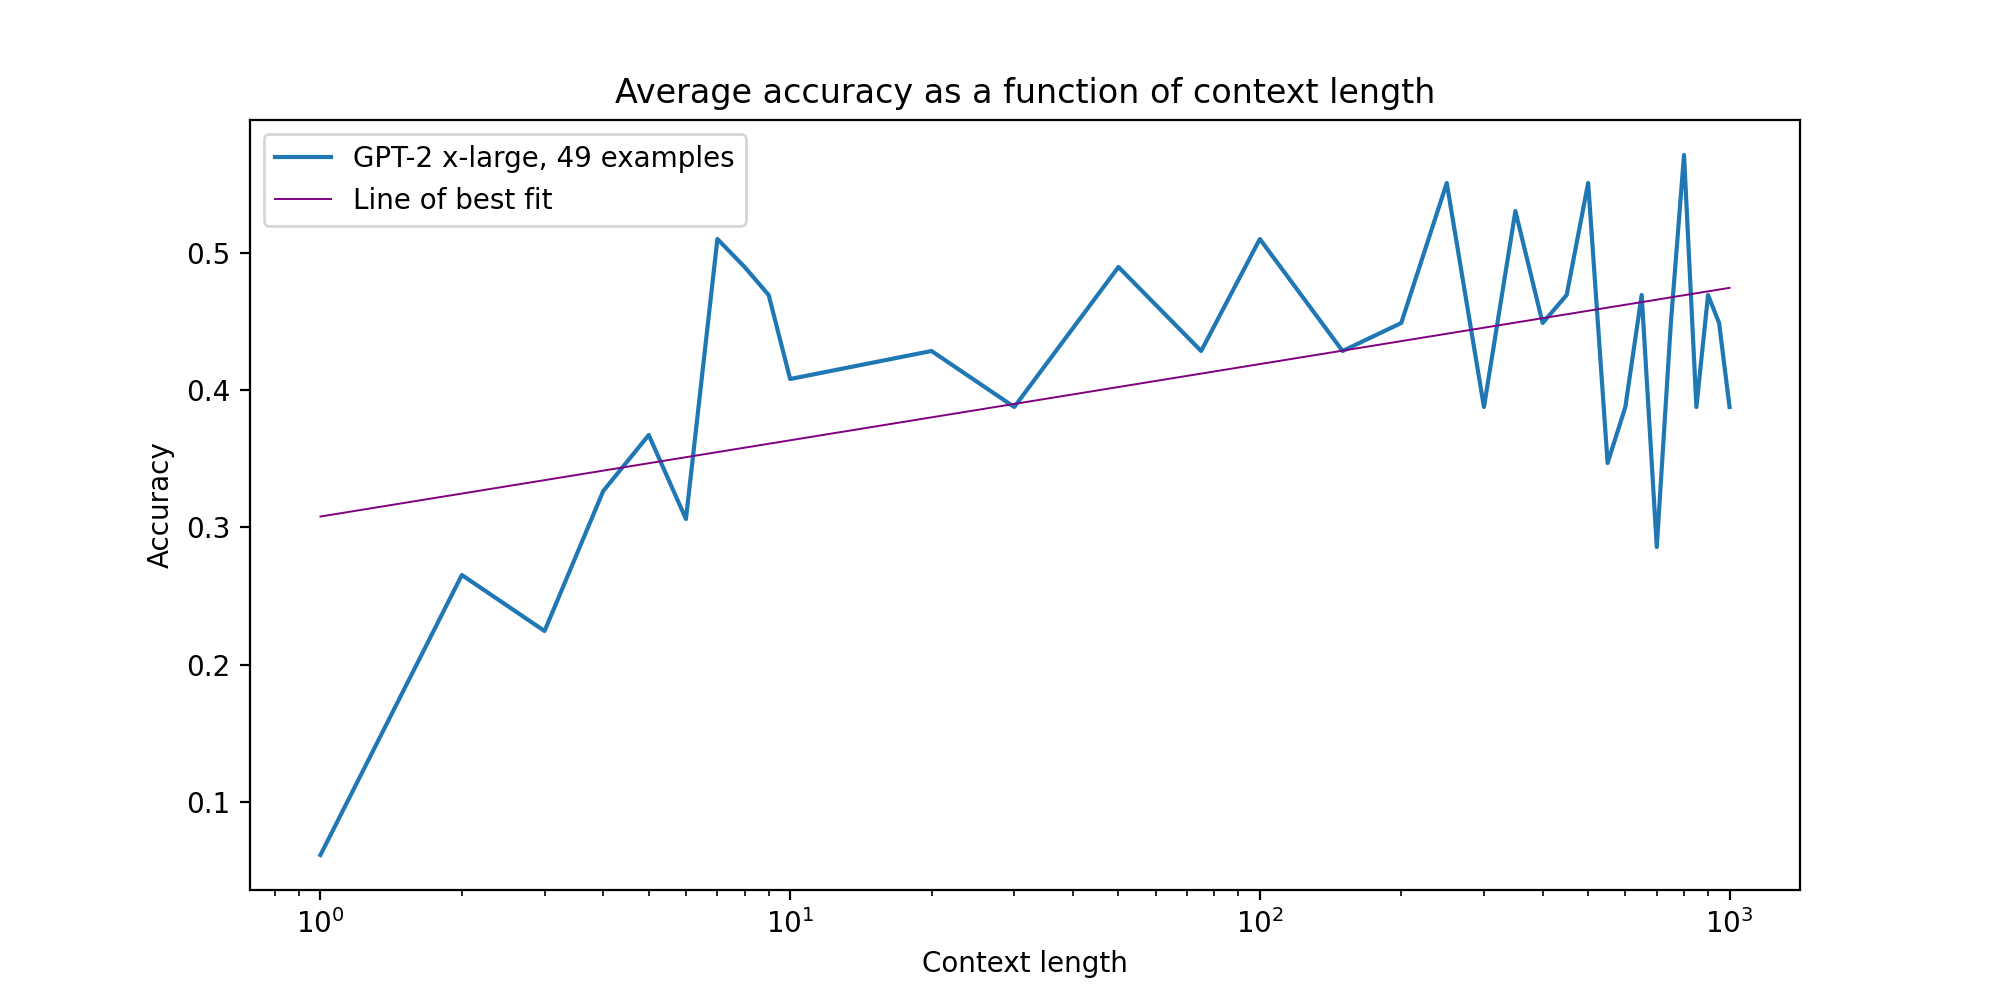

In [ ]:
plot(output_filename="gpt2large_datav1_clv2.json", label_line='GPT-2 x-large, 49 examples')

##### GPT-2 small, 33 context lengths, 75 examples

In [ ]:
input_ids, attention_mask = encode(text=text2, tokenizer=tokenizergpt2)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2, context_lengths=context_lengths, batch_size=16, file_name = "gpt2small_datav2_clv2.json")

In [ ]:
input_ids.size()

torch.Size([75, 1001])

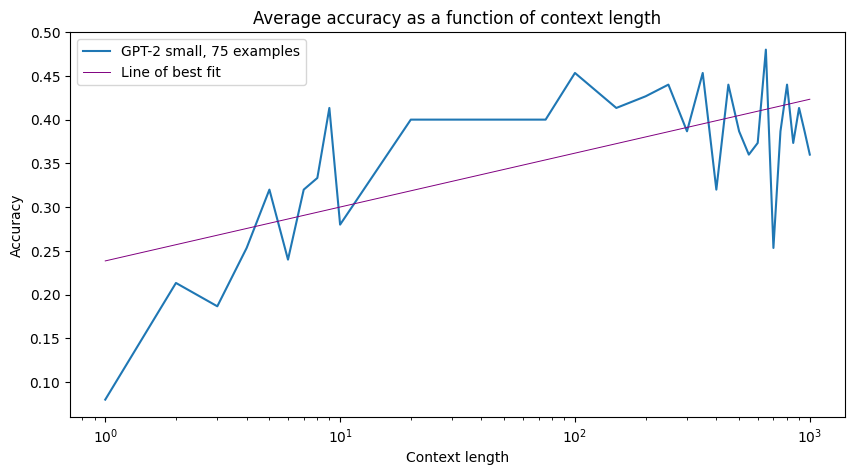

In [ ]:
plot(output_filename="gpt2small_datav2_clv2.json", label_line='GPT-2 small, 75 examples')

##### GPT-2 x-large, 33 context lengths, 75 examples

In [ ]:
input_ids, attention_mask = encode(text=text2, tokenizer=tokenizergpt2_large)
context_lengths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
output = measure_accuracy(input_ids=input_ids, attention_mask=attention_mask, model=modelgpt2_large, context_lengths=context_lengths, batch_size=8, file_name = "gpt2large_datav2_clv2.json")

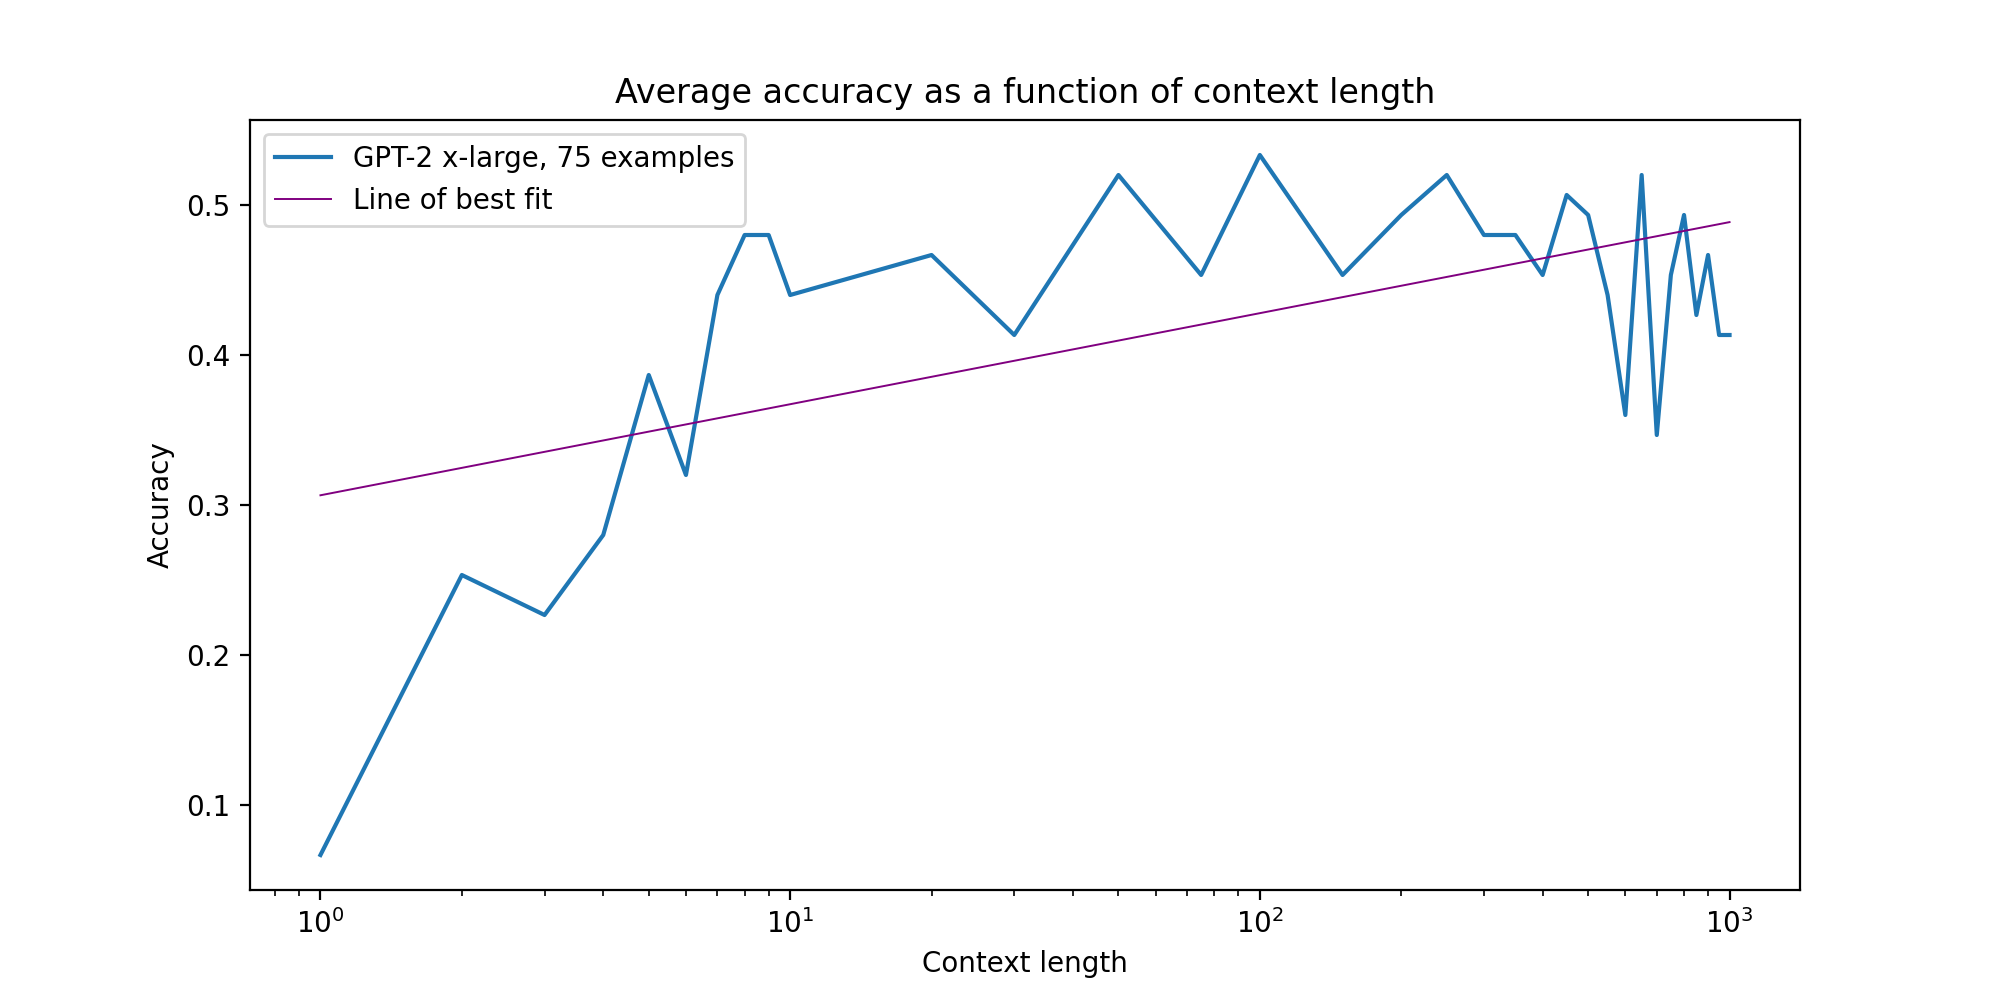

In [ ]:
plot(output_filename="gpt2large_datav2_clv2.json", label_line='GPT-2 x-large, 75 examples')

/usr/local/lib/python3.10/dist-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


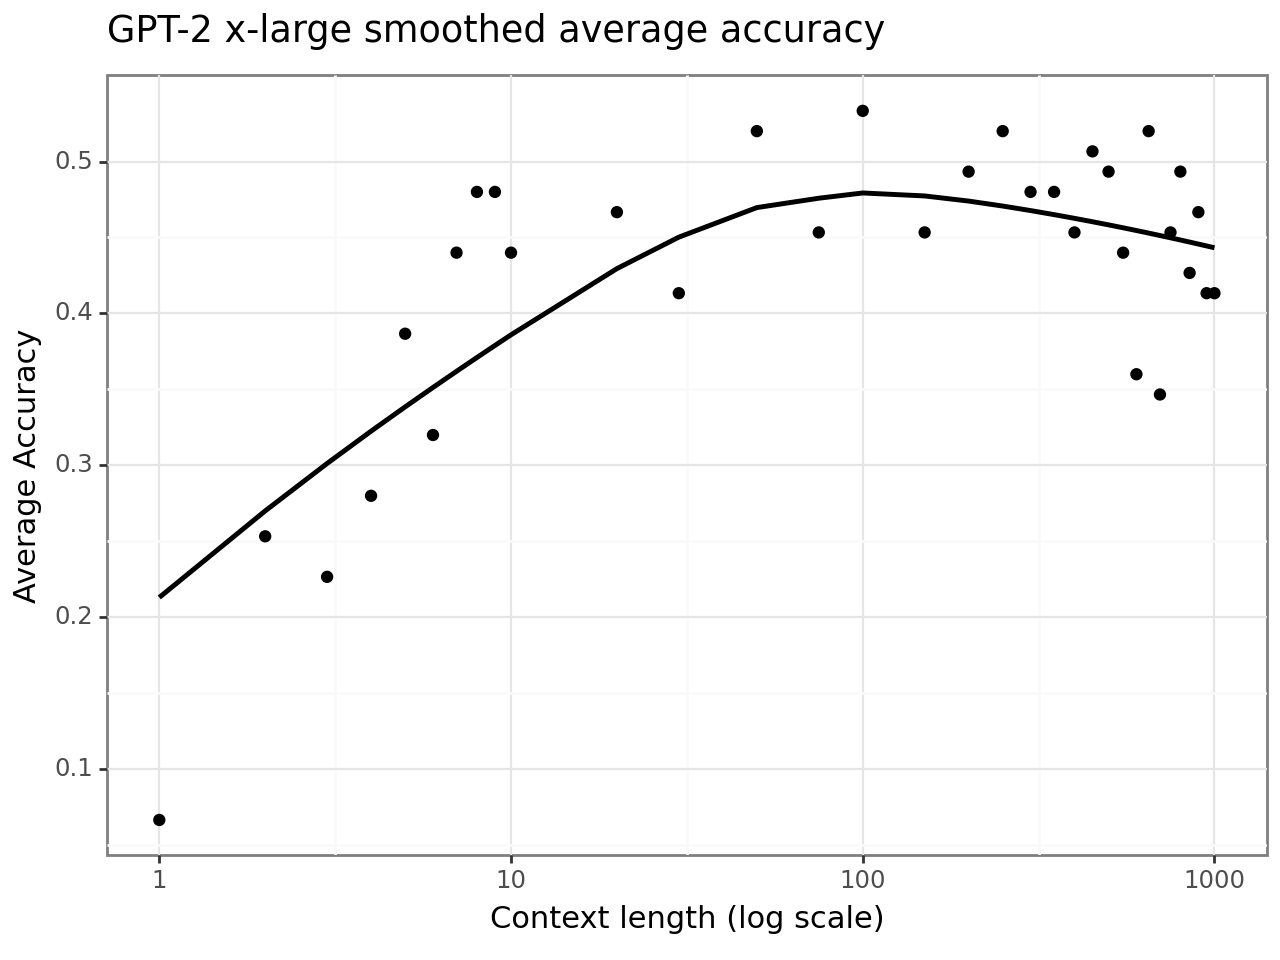

<Figure Size: (640 x 480)>

In [ ]:
from plotnine import (
    ggplot,
    aes,
    geom_point,
    geom_smooth,
    labs,
    theme_bw,
    scale_x_log10
)
from plotnine.data import mpg
from plotnine import scales
with open("gpt2large_datav2_clv2.json") as f:
  content = f.read()
acc_large = json.loads(content)
x_n = np.log10(np.array(list(acc_large), dtype='float64'))
y_n = np.array(list(acc_large.values()), dtype='float64')
d = pd.DataFrame({"x": x_n, "y": y_n})
(
    ggplot(d, aes(x='x', y='y'))
    + geom_point()
    + geom_smooth()
    + labs(x='Context length (log scale)', y='Average Accuracy')
    + theme_bw()
    + scales.scale_x_continuous(labels=[1, 10, 100, 1000])
    + labels.ggtitle(title="GPT-2 x-large smoothed average accuracy")
)

### Comparisons

##### GPT-2 small vs x-large - 49 ex

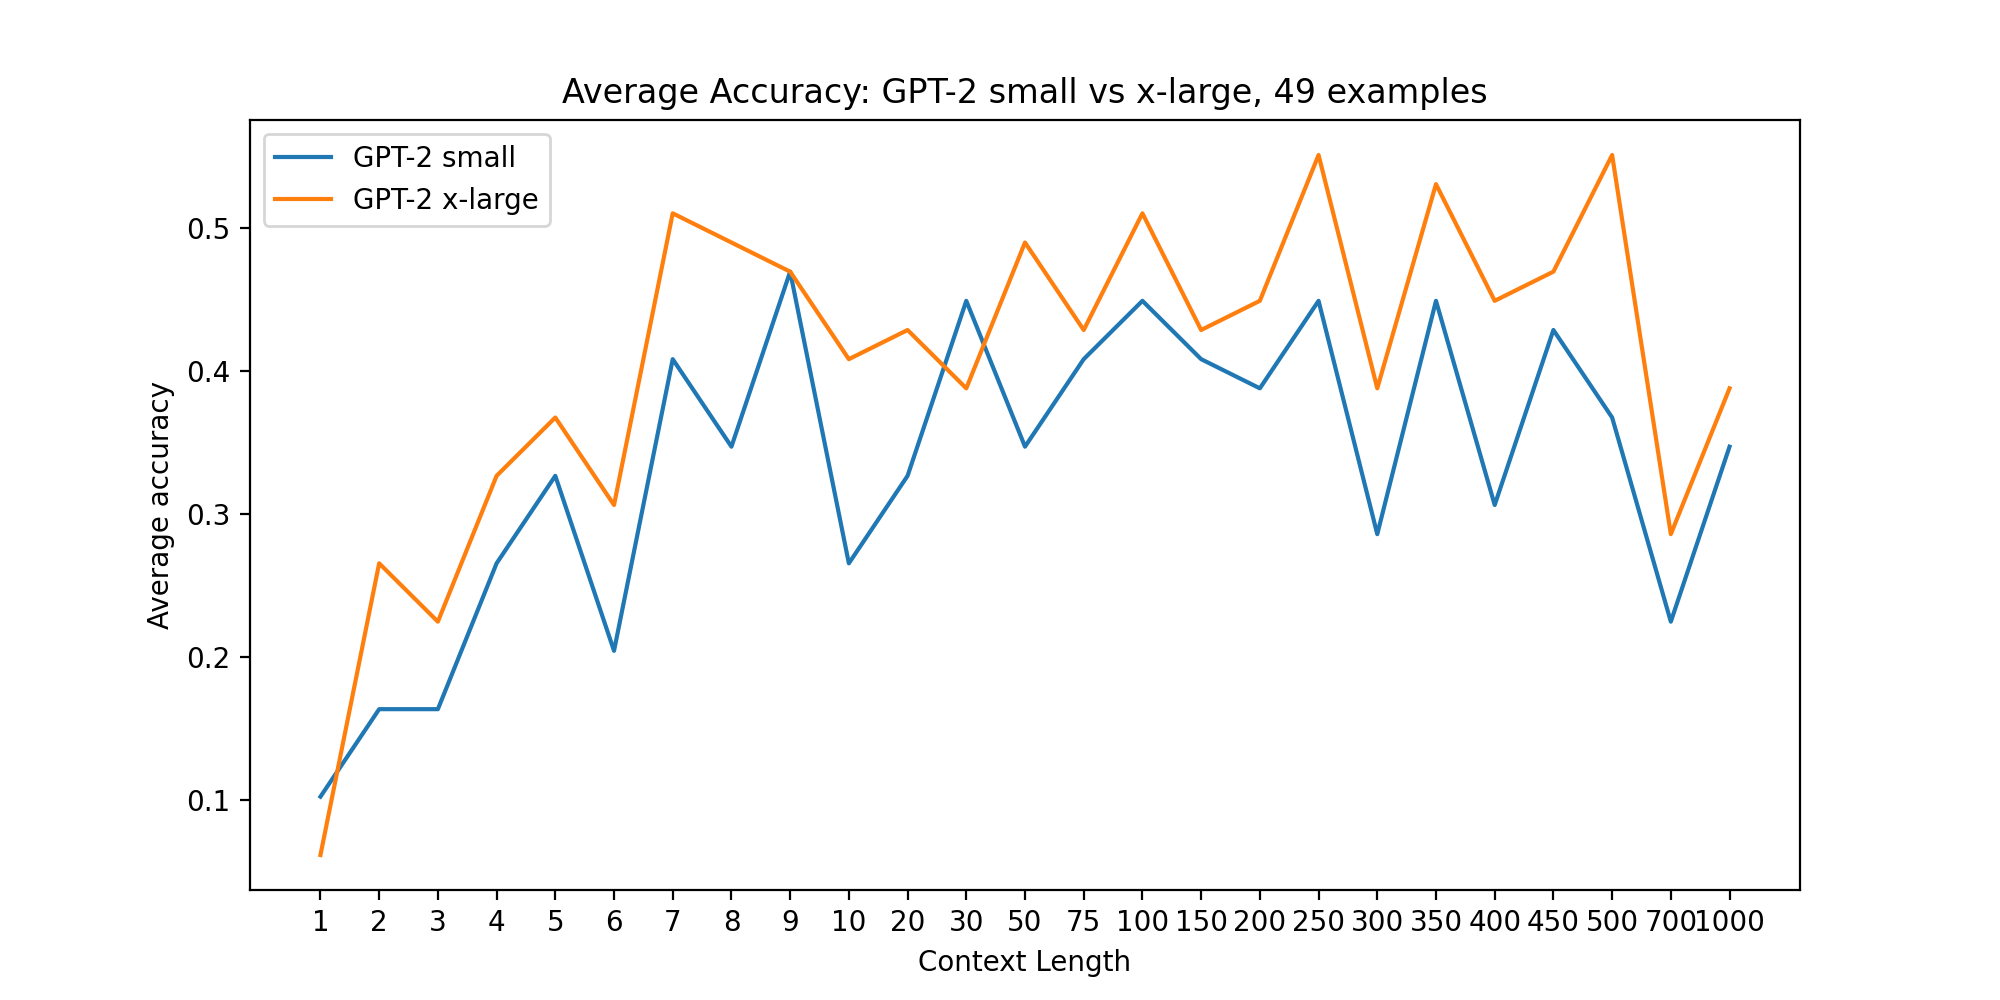

In [ ]:
with open("gpt2small_datav1_clv1.json") as f:
  content = f.read()
acc_small = json.loads(content)
with open("gpt2large_datav1_clv1.json") as f:
  content = f.read()
acc_large = json.loads(content)
x_1 = list(acc_small)
y_1 = np.array(list(acc_small.values()), dtype='float64')
x_2 = list(acc_large)
y_2 = np.array(list(acc_large.values()), dtype='float64')
plt.figure(figsize=(10, 5))
plt.plot(x_1, y_1, label="GPT-2 small")
plt.plot(x_2, y_2, label="GPT-2 x-large")
plt.legend()
plt.xlabel("Context Length")
plt.ylabel("Average accuracy")
plt.title("Average Accuracy: GPT-2 small vs x-large, 49 examples")
plt.show()

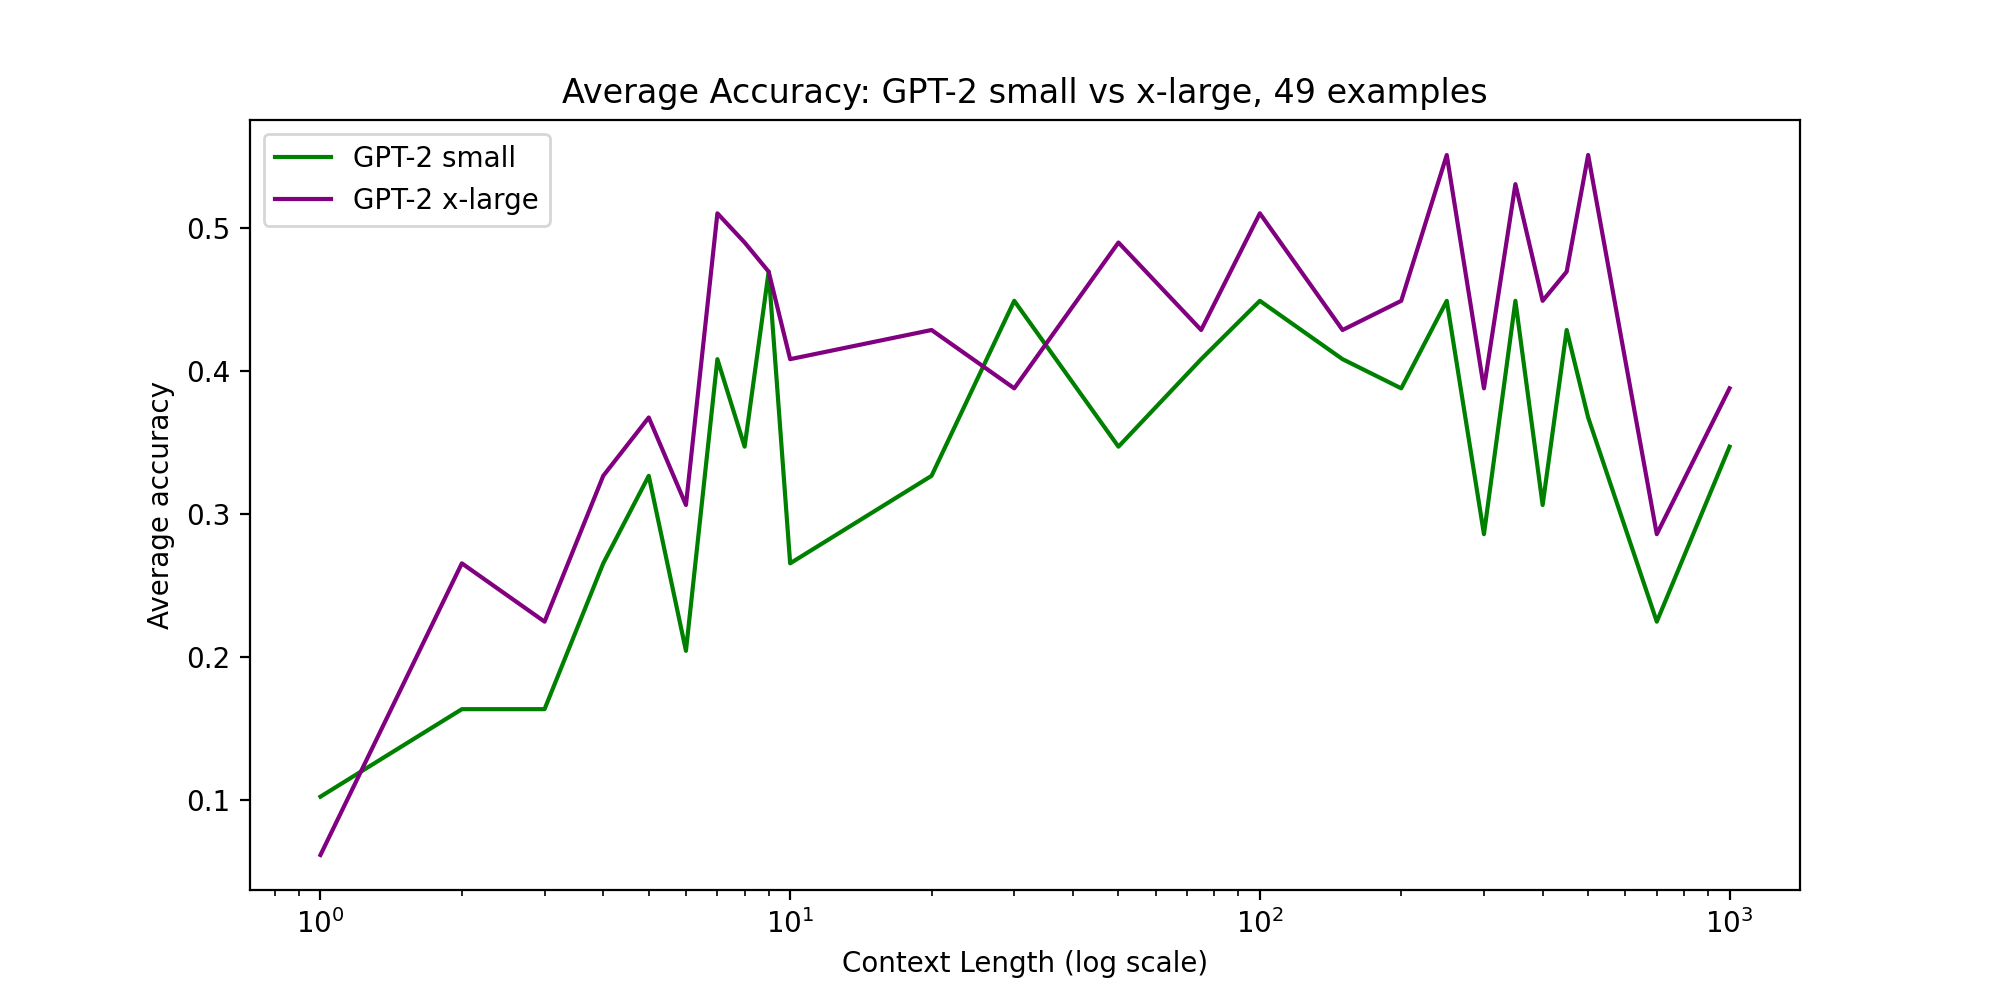

In [ ]:
with open("gpt2small_datav1_clv1.json") as f:
  content = f.read()
acc_small = json.loads(content)
with open("gpt2large_datav1_clv1.json") as f:
  content = f.read()
acc_large = json.loads(content)
x_1 = np.array(list(acc_small), dtype='int')
y_1 = np.array(list(acc_small.values()), dtype='float64')
x_2 = np.array(list(acc_large), dtype='float64')
y_2 = np.array(list(acc_large.values()), dtype='float64')
plt.figure(figsize=(10, 5))
plt.plot(x_1, y_1, label="GPT-2 small", color="green")
plt.plot(x_2, y_2, label="GPT-2 x-large", color="purple")
plt.xscale('log')
#plt.xticks(x_1, x_1)
plt.legend()
plt.xlabel("Context Length (log scale)")
plt.ylabel("Average accuracy")
plt.title("Average Accuracy: GPT-2 small vs x-large, 49 examples")
plt.show()

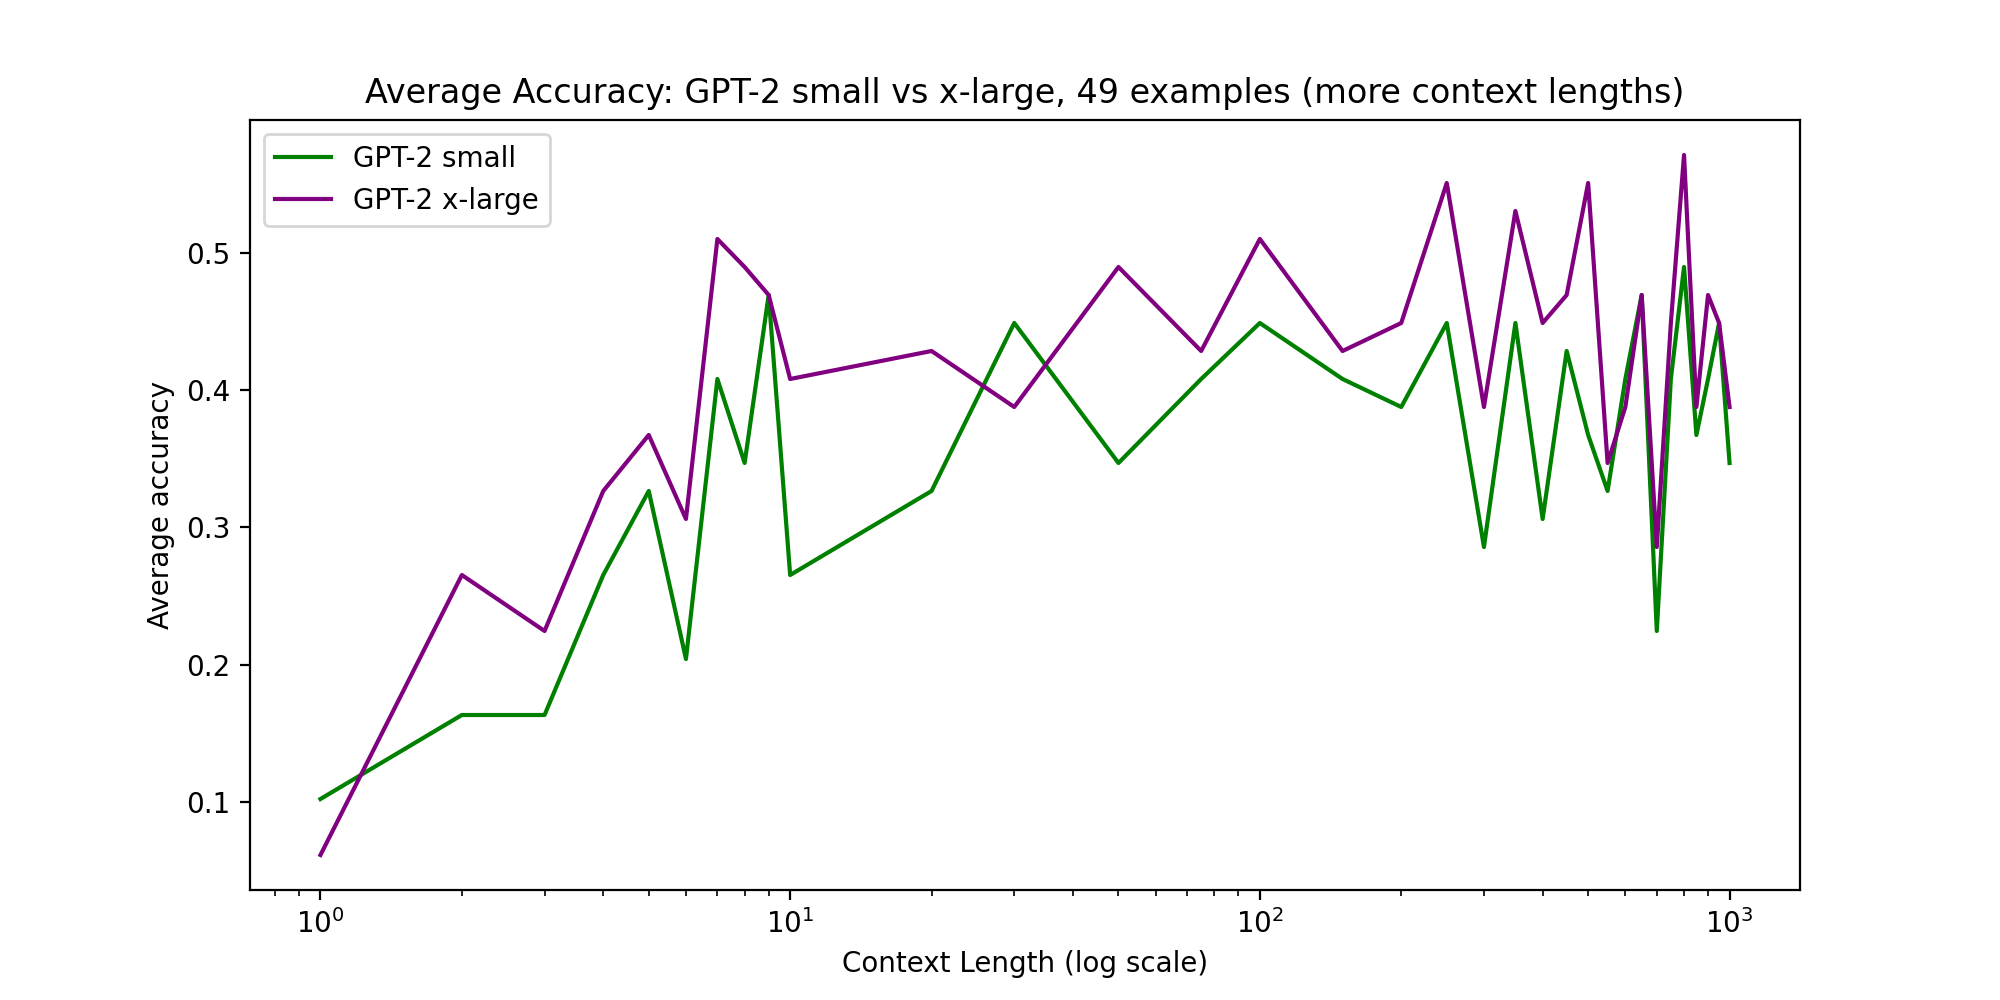

In [ ]:
with open("gpt2small_datav1_clv2.json") as f:
  content = f.read()
acc_small = json.loads(content)
with open("gpt2large_datav1_clv2.json") as f:
  content = f.read()
acc_large = json.loads(content)
x_1 = np.array(list(acc_small), dtype='float64')
y_1 = np.array(list(acc_small.values()), dtype='float64')
x_2 = np.array(list(acc_large), dtype='float64')
y_2 = np.array(list(acc_large.values()), dtype='float64')
plt.figure(figsize=(10, 5))
plt.plot(x_1, y_1, label="GPT-2 small", color="green")
plt.plot(x_2, y_2, label="GPT-2 x-large", color="purple")
plt.xscale('log')
plt.legend()
plt.xlabel("Context Length (log scale)")
plt.ylabel("Average accuracy")
plt.title("Average Accuracy: GPT-2 small vs x-large, 49 examples (more context lengths)")
plt.show()

##### GPT-2 small vs x-large - 75 ex

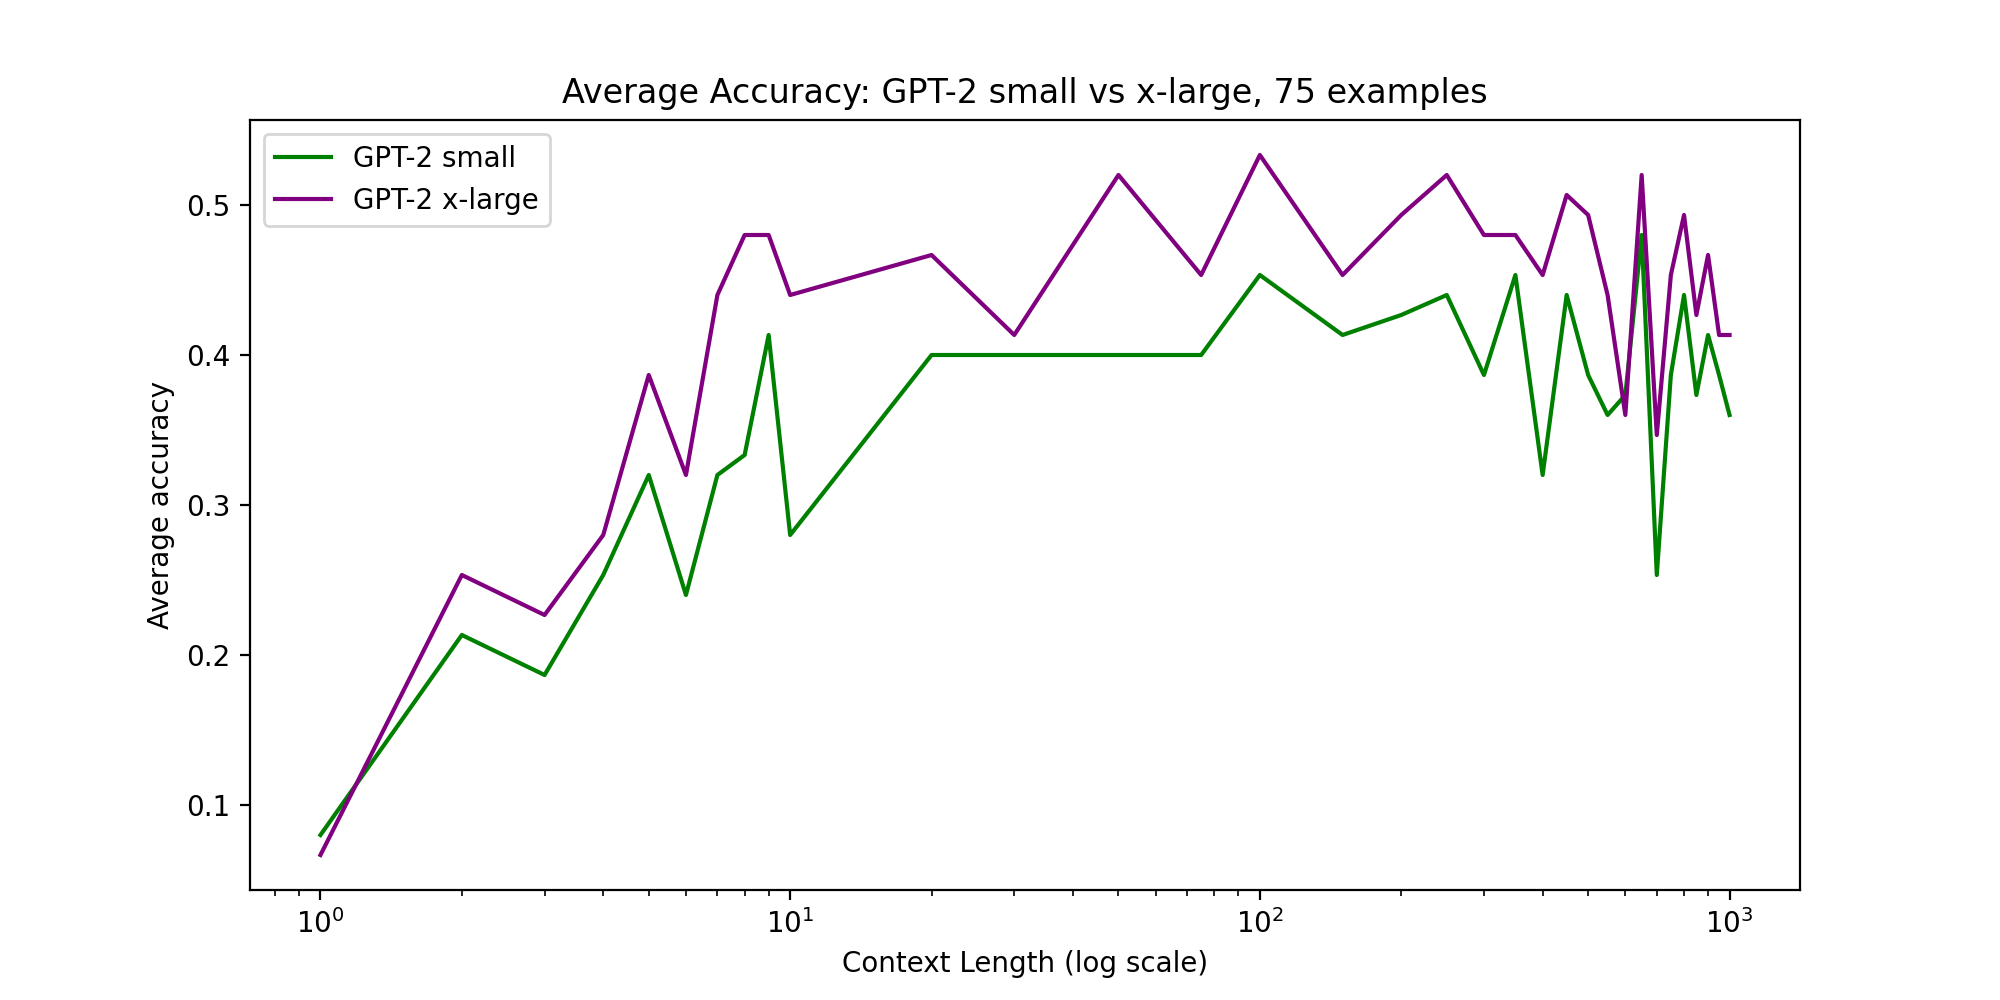

In [ ]:
with open("gpt2small_datav2_clv2.json") as f:
  content = f.read()
acc_small = json.loads(content)
with open("gpt2large_datav2_clv2.json") as f:
  content = f.read()
acc_large = json.loads(content)
x_1 = np.array(list(acc_small), dtype='float64')
y_1 = np.array(list(acc_small.values()), dtype='float64')
x_2 = np.array(list(acc_large), dtype='float64')
y_2 = np.array(list(acc_large.values()), dtype='float64')
plt.figure(figsize=(10, 5))
plt.plot(x_1, y_1, label="GPT-2 small", color='green')
plt.plot(x_2, y_2, label="GPT-2 x-large", color='purple')
plt.xscale('log')
plt.legend()
plt.xlabel("Context Length (log scale)")
plt.ylabel("Average accuracy")
plt.title("Average Accuracy: GPT-2 small vs x-large, 75 examples")
plt.show()

##### GPT-2 small (49 ex vs 75 ex)

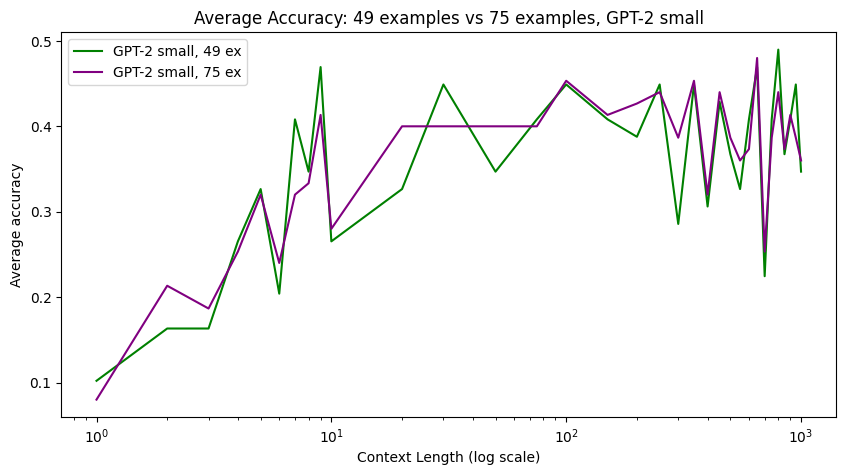

In [ ]:
with open("gpt2small_datav1_clv2.json") as f:
  content = f.read()
acc_small = json.loads(content)
with open("gpt2small_datav2_clv2.json") as f:
  content = f.read()
acc_small_data2 = json.loads(content)
x_1 = np.array(list(acc_small), dtype='float64')
y_1 = np.array(list(acc_small.values()), dtype='float64')
x_2 = np.array(list(acc_small_data2), dtype='float64')
y_2 = np.array(list(acc_small_data2.values()), dtype='float64')
plt.figure(figsize=(10, 5))
plt.plot(x_1, y_1, label="GPT-2 small, 49 ex", color='green')
plt.plot(x_2, y_2, label="GPT-2 small, 75 ex", color='purple')
plt.xscale('log')
plt.legend()
plt.xlabel("Context Length (log scale)")
plt.ylabel("Average accuracy")
plt.title("Average Accuracy: 49 examples vs 75 examples, GPT-2 small")
plt.show()

##### GPT-2 x-large (45 ex vs 75 ex)

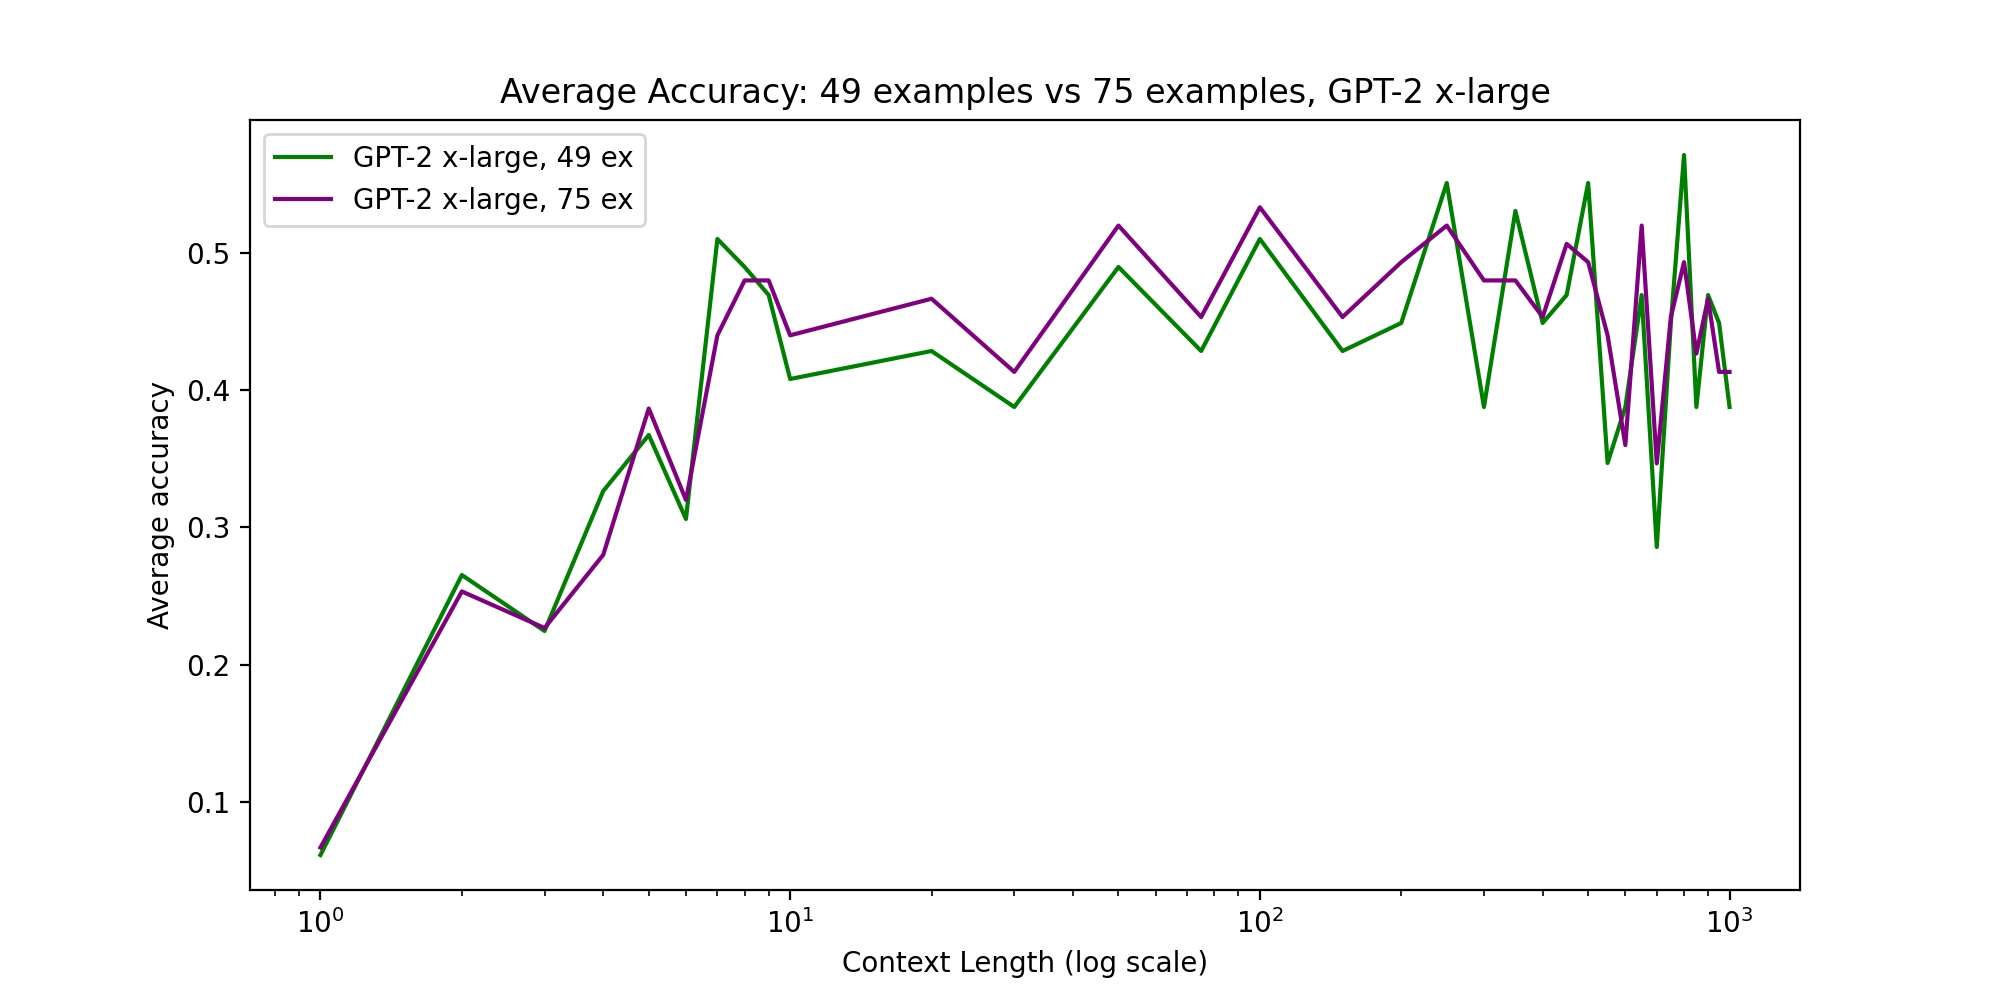

In [ ]:
with open("gpt2large_datav1_clv2.json") as f:
  content = f.read()
acc_small = json.loads(content)
with open("gpt2large_datav2_clv2.json") as f:
  content = f.read()
acc_small_data2 = json.loads(content)
x_1 = np.array(list(acc_small), dtype='float64')
y_1 = np.array(list(acc_small.values()), dtype='float64')
x_2 = np.array(list(acc_small_data2), dtype='float64')
y_2 = np.array(list(acc_small_data2.values()), dtype='float64')
plt.figure(figsize=(10, 5))
plt.plot(x_1, y_1, label="GPT-2 x-large, 49 ex", color='green')
plt.plot(x_2, y_2, label="GPT-2 x-large, 75 ex", color='purple')
plt.xscale('log')
plt.legend()
plt.xlabel("Context Length (log scale)")
plt.ylabel("Average accuracy")
plt.title("Average Accuracy: 49 examples vs 75 examples, GPT-2 x-large")
plt.show()